#Implemention of Fully connected neutral network by pytorch

The goal of this task is to implement a simple fully connected neural network to classify grayscale images of handwritten digits (0 - 9) from the MNIST dataset. In this task will use torch to implement.

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
#loading
(train_X, train_y), (test_X, test_y) = mnist.load_data()
# Reshape data from 3D to 2D
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1]**2)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1]**2)

This dataset contains 60,000 training images and 10,000 testing images. We will remove 10,000 images from the training set and call this our validation set. Each image is 28 × 28 pixels in size, and is generally represented as a flat vector of 784 numbers. The dataset also includes labels for each image.

In [3]:
'''# load data set
train_data = np.loadtxt('train_data.csv', delimiter=',',skiprows=1)[:,1:]
train_labels = np.loadtxt('train_labels.csv', delimiter=',',skiprows=1)[:,1:]
test_data = np.loadtxt('test_data.csv', delimiter=',',skiprows=1)[:,1:]
test_labels = np.loadtxt('test_labels.csv', delimiter=',',skiprows=1)[:,1:]
'''

"# load data set\ntrain_data = np.loadtxt('train_data.csv', delimiter=',',skiprows=1)[:,1:]\ntrain_labels = np.loadtxt('train_labels.csv', delimiter=',',skiprows=1)[:,1:]\ntest_data = np.loadtxt('test_data.csv', delimiter=',',skiprows=1)[:,1:]\ntest_labels = np.loadtxt('test_labels.csv', delimiter=',',skiprows=1)[:,1:]\n"

To shuffle the training set and remove 10,000 images randomly to form our validation set. Set the batch size to B = 1000. This means that we will pass through the entire data in 50 iterations, which is called on epoch.

In [4]:
# Set seed
np.random.seed(0)
batch_size = 1000
epochs = 50
# Randomize training set and pick validation set
order = np.random.permutation(train_X.shape[0])
val_X = torch.tensor(train_X[order[0:10000],:])
val_Y = torch.tensor(train_y[order[0:10000]])
train_X = torch.tensor(train_X[order[10000:],:])
train_Y = torch.tensor(train_y[order[10000:]])
test_X = torch.tensor(test_X)
test_Y = torch.tensor(test_y)

# By using DataLoader load datasets multi-process 
val_dataset = TensorDataset(val_X,val_Y)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
train_dataset = TensorDataset(train_X,train_Y)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataset = TensorDataset(test_X,test_Y)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

Define a NeuralNetwork class with 300 hidden units and initialize the weights of the network by sampling from a standard normal distribution.
Initialize the bias terms to zero.

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layer):
        super().__init__()
        # Inputs to hidden layer linear transformation
        #input_dim:784 output_dim:10 hidden_units:300
        
        self.hidden = nn.Linear(input_dim, hidden_layer)
        
        # Initial weights and bias terns of network
        
        torch.nn.init.xavier_normal_(self.hidden.weight)
        torch.nn.init.zeros_(self.hidden.bias)
        
        # Hidden layer to output layer, 10 digit
        
        self.output = nn.Linear(hidden_layer, output_dim)
        
        # Initial weights and bias terns of network
        
        torch.nn.init.xavier_normal_(self.output.weight)
        torch.nn.init.zeros_(self.output.bias)

        # Define sigmoid activation and softmax output
        
        self.sigmoid = nn.Sigmoid()  
        
    def forward(self, x):
        # Pass the input tensor through each of operations
        x = x.to(torch.float32)
        x_hidden = self.hidden(x)
        x_sigmoid = self.sigmoid(x_hidden)
        x_out = self.output(x_sigmoid)
        out = x_out.to(torch.float64)
        return out    
    

In [6]:
input_dim = 784
output_dim = 10
hidden_layer = 300
epochs = 30
loss_val = np.zeros([epochs,1])
loss_train = np.zeros([epochs,1])
acc_train = np.zeros([epochs,1])
acc_val = np.zeros([epochs,1])
accuracy_tr_list = []
accuracy_val_list = []
learning_rate = 0.01

model = NeuralNetwork(input_dim, output_dim, hidden_layer)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
criterion = torch.nn.CrossEntropyLoss()

In [7]:
# Loop over epochs
for epoch in range(epochs):    
    # Loop over batches in an epoch using DataLoader
    loss_tr = []
    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
        # x_batch.shape:1000*784 /y_batch:1000*1 /y_batch_pred.shape:1000*10
        y_batch = y_batch.long()
        y_batch_pred = model(x_batch)
        loss = criterion(y_batch_pred, y_batch.squeeze())
        loss_tr.append(loss.detach().numpy())
     
        optimizer.zero_grad()
        #loss.requires_grad = True
        loss.backward()
        optimizer.step()
        total_tr = y_batch.size(0)
        correct_tr = (torch.argmax(y_batch_pred,dim=1) == y_batch.squeeze()).sum()
        accuracy_tr = 100 * correct_tr / total_tr
        accuracy_tr_list.append(accuracy_tr)
   
    acc_train[epoch] = np.mean(accuracy_tr_list)    
    loss_train[epoch] = np.mean(loss_tr)
    
    # Validation set
    for id_batch, (x_batch, y_batch) in enumerate(val_dataloader):
        optimizer.zero_grad()
        y_batch = y_batch.long()
        y_batch_pred = model(x_batch)
        validation_loss = criterion(y_batch_pred, y_batch.squeeze())   
        
        total_val = y_batch.size(0)
        correct_val = (torch.argmax(y_batch_pred,dim=1) == y_batch.squeeze()).sum()
        accuracy_val = 100 * correct_val / total_val
        accuracy_val_list.append(accuracy_val)
    
    acc_val[epoch] = np.mean(accuracy_val_list) 
    loss_val[epoch] = np.mean(validation_loss.detach().numpy())

torch.save(model, './unregularized_model')

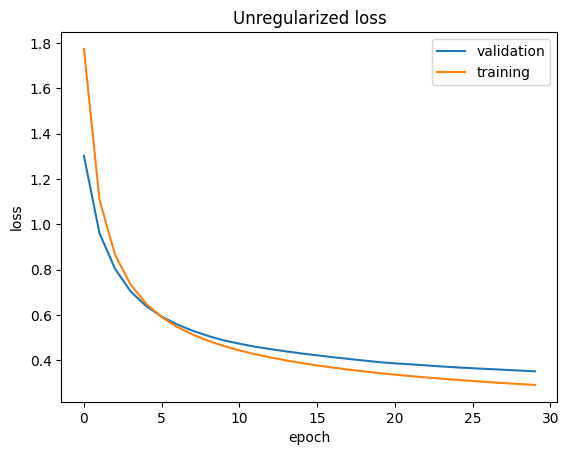

In [8]:
plt.plot(loss_val)
plt.plot(loss_train)
plt.legend(['validation','training'])
plt.title('Unregularized loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

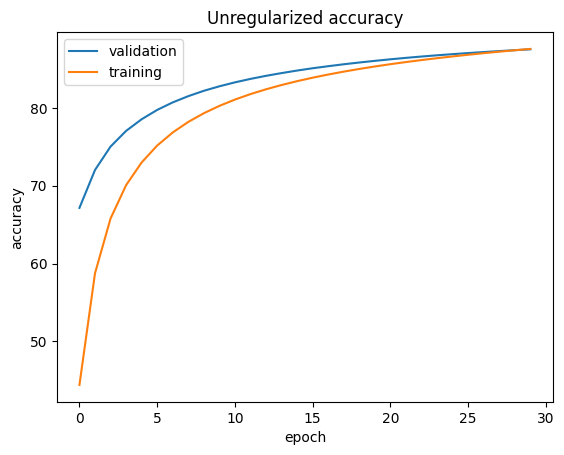

In [9]:
plt.plot(acc_val)
plt.plot(acc_train)
plt.legend(['validation','training'])
plt.title('Unregularized accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [10]:
print(f"training:{np.max(acc_train)}, validation:{np.max(acc_val)}")

training:87.57279968261719, validation:87.52266693115234


# Regularization 

Now, add a regularization term to the cross entropy loss. The regularized loss function corresponding to the mini-batch becomes\
$J(B,\theta) + \lambda( \left\| W_1 \right\|^2 + \left\| W_2 \right\|^2 )$ \
where $\lambda$ is now a is now a hyperparameter. Here, W1, W2 are the weight matrices and do not include the bias term. Do not penalize the bias. Set $\lambda = 0.0001$, implement the regularized version of the neural network, and plot.


In [11]:
# Set seed
np.random.seed(0)
lamda = 0.0001
input_dim = 784
output_dim = 10
hidden_layer = 300
epochs = 30
loss_val = np.zeros([epochs,1])
loss_train = np.zeros([epochs,1])
acc_train = np.zeros([epochs,1])
acc_val = np.zeros([epochs,1])
accuracy_tr_list = []
accuracy_val_list = []

model = NeuralNetwork(input_dim, output_dim, hidden_layer)
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
criterion = torch.nn.CrossEntropyLoss()


In [12]:
# Loop over epochs
for epoch in range(epochs):
    # Loop over batches in an epoch using DataLoader
    loss_tr = []
    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
               
        y_batch = y_batch.long()
        y_batch_pred = model(x_batch)
        loss = criterion(y_batch_pred, y_batch.squeeze())
        
        # Add a regularization term
        w_1 = list(model.parameters())[0]
        w_2 = list(model.parameters())[1]
        loss = loss + lamda * (torch.linalg.norm(w_1) ** 2 + torch.linalg.norm(w_2) ** 2)
        loss_tr.append(loss.detach().numpy())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_tr = y_batch.size(0)
        correct_tr = (torch.argmax(y_batch_pred,dim=1) == y_batch.squeeze()).sum()
        accuracy_tr = 100 * correct_tr / total_tr
        accuracy_tr_list.append(accuracy_tr)
        
    acc_train[epoch] = np.mean(accuracy_tr_list)    
    loss_train[epoch] = np.mean(loss_tr)
    
    # Validation set
    
    for id_batch, (x_batch, y_batch) in enumerate(val_dataloader):      
        y_batch = y_batch.long()
        y_batch_pred = model(x_batch)
        validation_loss = criterion(y_batch_pred, y_batch.squeeze())
        optimizer.zero_grad()
        w_1 = list(model.parameters())[0]
        w_2 = list(model.parameters())[2]
        validation_loss = validation_loss + lamda * (torch.linalg.norm(w_1) ** 2 + torch.linalg.norm(w_2) ** 2)     
        validation_loss.backward()
        optimizer.step()
        total_val = y_batch.size(0)
        correct_val = (torch.argmax(y_batch_pred,dim=1) == y_batch.squeeze()).sum()
        accuracy_val = 100 * correct_val / total_val
        accuracy_val_list.append(accuracy_val)
    
    acc_val[epoch] = np.mean(accuracy_val_list) 
    loss_val[epoch] = np.mean(validation_loss.detach().numpy())
    
torch.save(model, './regularized_model')

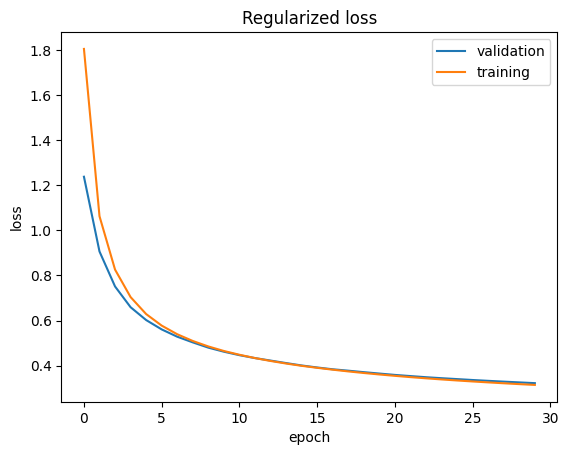

In [13]:
plt.plot(loss_val)
plt.plot(loss_train)
plt.legend(['validation','training'])
plt.title('Regularized loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

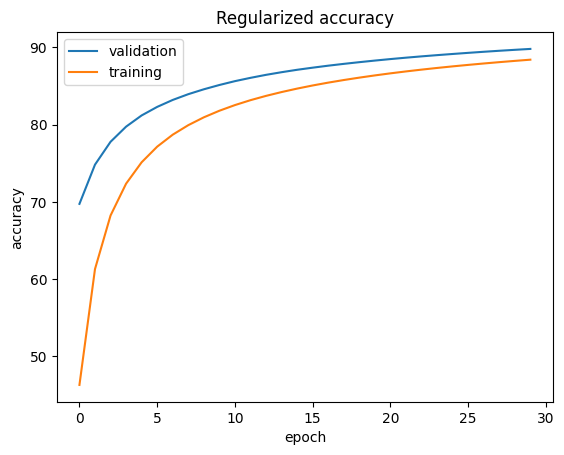

In [14]:
plt.plot(acc_val)
plt.plot(acc_train)
plt.legend(['validation','training'])
plt.title('Regularized accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [15]:
print(f"training:{np.max(acc_train)}, validation:{np.max(acc_val)}")

training:88.40666961669922, validation:89.7993392944336


# Evaluation result

In [16]:
unregularized_model = torch.load('./unregularized_model')
unregularized_model.eval()

regularized_model = torch.load('./regularized_model')
regularized_model.eval()


NeuralNetwork(
  (hidden): Linear(in_features=784, out_features=300, bias=True)
  (output): Linear(in_features=300, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)

In [17]:
y_test_pred = unregularized_model(test_X)
total_test = y_test_pred.size(0)
correct_test = (torch.argmax(y_test_pred,dim=1) == test_Y.squeeze()).sum()
acc_test_unregular = 100 * correct_test / total_test


In [18]:
y_test_pred = regularized_model(test_X)
total_test = y_test_pred.size(0)
correct_test = (torch.argmax(y_test_pred,dim=1) == test_Y.squeeze()).sum()
acc_test_regular = 100 * correct_test / total_test

In [19]:
print(f"The accuracy of the unregularized model: {acc_test_unregular}%")
print(f"The accuracy of the regularized model: {acc_test_regular}%")

The accuracy of the unregularized model: 91.37000274658203%
The accuracy of the regularized model: 91.77999877929688%
